In [27]:
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix, precision_recall_curve
)
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [28]:
FEATURE_COLUMNS = [
    'B', 'COM_RAT', 'Cyclic', 'D',
   'Dcy*', 'DIT', 'DPT*', 'E', 'Inner', 'LCOM', 'Level', 'LOC', 'N',
   'NCLOC', 'NOAC', 'NOC', 'NOIC', 'OCmax', 'PDcy', 'PDpt', 'STAT', 'SUB',
   'TCOM_RAT', 'V', 'WMC', 'CBO', 'CLOC', 'Command', 'CONS', 'CSA', 'CSO',
   'CSOA', 'Dcy', 'DPT', 'INNER', 'jf', 'JLOC', 'Jm', 'Level*', 'MPC', 'n',
   'NAAC', 'NAIC', 'NOOC', 'NTP', 'OCavg', 'OPavg', 'OSavg', 'OSmax',
   'Query', 'RFC', 'TODO'
]
# FEATURE_COLUMNS = [
#     "B","COM_RAT","Cyclic","D","Dcy*","DIT","DPT*","E","INNER",
#     "LCOM","Level","LOC","N","NCLOC","NOAC","NOC","NOIC","OCmax","PDcy","PDpt",
#     "STAT","SUB","TCOM_RAT","V","WMC"
# ]
LABEL_COLUMN = "1适合LLM"

def load_data(data_path, target_col=FEATURE_COLUMNS):
    df = pd.read_excel(data_path)
    # for key in ['CC', 'MC', 'CC-1', 'MC-1']:
    #     df[key] = pd.to_numeric(df[key].str.split('%', expand=True)[0]) / 100
    df_check = df.isnull().any(axis=1)
    print('NaN: ', df[df_check])
    df = df.fillna(-1)
    
    x = df[target_col].to_numpy()
    y = df[LABEL_COLUMN].to_numpy()
    return x, y

train_x, train_y = load_data('./data.xlsx')

# test_x, test_y = load_data('./project_test.xlsx')

NaN:                       testart          CC             MC     BC     LC  \
30             ToStringStyle  100% (6/6)  87% (107/123)  0.648  0.807   
31         AtomicInitializer    0% (0/1)       0% (0/2)  0.000  0.000   
32     AtomicSafeInitializer    0% (0/1)       0% (0/2)  0.000  0.000   
33     BackgroundInitializer    0% (0/2)      0% (0/14)  0.000  0.000   
40           LazyInitializer    0% (0/1)       0% (0/2)  0.000  0.000   
...                      ...         ...            ...    ...    ...   
1008  NormalizedMatrixSeries  100% (1/1)    66.7% (4/6)    NaN  0.467   
1012            VectorSeries  100% (1/1)     90% (9/10)    NaN  0.812   
1016         XIntervalSeries  100% (1/1)     100% (9/9)    NaN  1.000   
1024        XYIntervalSeries  100% (1/1)   100% (11/11)    NaN  1.000   
1031         YIntervalSeries  100% (1/1)     100% (9/9)    NaN  1.000   

                         mio        CC-1             MC-1   BC-1   LC-1  ...  \
30             ToStringStyle  100% (6

C:\Users\17958\AppData\Local\Temp\ipykernel_70760\3565401934.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(distance_matrix, method='ward')


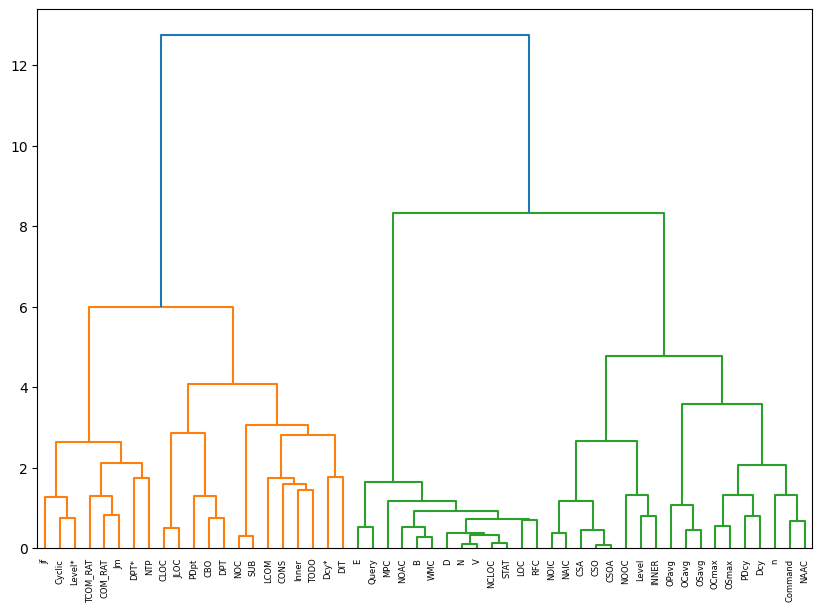

[14  2  1 14 11 12  3 13  8 10 16 14 14 14 14  7 15 18 18  6 14  7  2 14
 14  6  5 19  9 15 15 15 18  6 16  1  5  2  1 14 19 19 15 16  4 17 17 17
 18 13 14  8]


In [29]:
df = pd.read_excel('./data.xlsx')
# for key in ['CC', 'MC', 'CC-1', 'MC-1']:
#     df[key] = pd.to_numeric(df[key].str.split('%', expand=True)[0]) / 100
df_check = df.isnull().any(axis=1)
df = df.fillna(-1)
corr = df[FEATURE_COLUMNS].corr()
distance_matrix = 1 - corr
Z = sch.linkage(distance_matrix, method='ward')
plt.figure(figsize=(10, 7))
sch.dendrogram(Z, labels=corr.columns)
plt.show()
max_d = 1.5
clusters = fcluster(Z, max_d, criterion='distance')
print(clusters)

In [30]:
_ids_list = []
_names_list = []
for _idx in range(max(clusters)):
    _ids = np.where(clusters == _idx+1)[0][0]
    _ids_list.append(_ids)
    _names_list.append(corr.columns[_ids])
print(_ids_list)
print(_names_list)
train_x = train_x[:, _ids_list]

# 
# # 定义自定义的列名列表
# custom_features = ['Cyclic',  'DPT',
#                            'NTP', 'CLOC', 'NOC',
#                            'Inner', 'CONS', 'LCOM', 'Dcy*',
#                              'NOIC', 'Level',
#                            'OCmax', 'Command'] # 替换为你想要的列名
# 
# # 检查列名是否有效
# for feature in custom_features:
#     if feature not in corr.columns:
#         raise ValueError(f"列名 '{feature}' 在 corr.columns 中不存在")
# 
# # 获取索引
# _ids_list = [list(corr.columns).index(feature) for feature in custom_features]
# 
# # 记录选择的列名
# _names_list = custom_features
# 
# # 选择 train_x 的列
# train_x = train_x[:, _ids_list]
# 
# print(_ids_list)
# print(_names_list)

[2, 1, 6, 44, 26, 19, 15, 8, 28, 9, 4, 5, 7, 0, 16, 10, 45, 17, 27]
['Cyclic', 'COM_RAT', 'DPT*', 'NTP', 'CLOC', 'PDpt', 'NOC', 'Inner', 'CONS', 'LCOM', 'Dcy*', 'DIT', 'E', 'B', 'NOIC', 'Level', 'OCavg', 'OCmax', 'Command']


In [31]:
train_x.shape

(1034, 19)

In [32]:
scaler = StandardScaler()
scaler.fit(train_x)
print(scaler.mean_)
print(scaler.var_)

train_x = scaler.transform(train_x)
# test_x = scaler.transform(test_x)

train_x, val_x, train_y, val_y = train_test_split(
    train_x, train_y, test_size=0.4, random_state=42)

val_x, test_x, val_y, test_y = train_test_split(
    val_x, val_y, test_size=0.5, random_state=42)

print(train_x.shape, val_x.shape, test_x.shape)

[2.85435203e+01 1.26169293e-01 1.91301741e+02 5.60928433e-02
 2.14042553e+01 2.91682785e+00 6.38297872e-01 1.32495164e-01
 1.41972921e+00 2.70986460e+00 9.81005803e+01 1.94294004e+00
 8.57677911e+05 1.55935932e+00 4.18152805e+01 4.10541586e+00
 1.88222760e+00 5.78626692e+00 3.15957447e+00]
[2.54189994e+03 3.15491886e-02 5.34837001e+04 8.77626838e-02
 7.44007062e+03 1.09602004e+01 5.63295197e+01 5.01787391e-01
 1.46405950e+00 9.77268799e+00 1.02291988e+04 1.23368807e+00
 3.03142111e+13 2.35309520e+01 9.46943106e+03 1.25275722e+01
 1.36360590e+00 4.64001596e+01 7.90277275e+01]
(620, 19) (207, 19) (207, 19)


In [33]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 64)
        self.output = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x) + x)
        x = self.dropout(x)
        x = self.relu(self.layer3(x))
        x = self.dropout(x)
        x = self.relu(self.layer4(x) + x)
        x = self.dropout(x)
        x = self.output(x)
        return x

In [34]:
batch_size = 64
train_dataset = CustomDataset(train_x, train_y)
val_dataset = CustomDataset(val_x, val_y)
test_dataset = CustomDataset(test_x, test_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

num_features = len(_ids_list)
model = BinaryClassifier(input_dim=num_features)
criterion = nn.BCEWithLogitsLoss()  # 内置Sigmoid + 交叉熵
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 800
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BinaryClassifier(
  (layer1): Linear(in_features=19, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
)

In [35]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(inputs + torch.randn_like(inputs)*0.1)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    # 计算训练损失
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = correct / total
    
    # 验证阶段
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = correct / total
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Loss: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Epoch 1/800
Train Loss: 0.6648 | Train Loss: 0.5871 | Test Loss: 0.6001 | Test Acc: 0.7101
Epoch 2/800
Train Loss: 0.6153 | Train Loss: 0.6968 | Test Loss: 0.5585 | Test Acc: 0.7101
Epoch 3/800
Train Loss: 0.5800 | Train Loss: 0.6968 | Test Loss: 0.5304 | Test Acc: 0.7150
Epoch 4/800
Train Loss: 0.5490 | Train Loss: 0.7016 | Test Loss: 0.4982 | Test Acc: 0.7198
Epoch 5/800
Train Loss: 0.5229 | Train Loss: 0.7065 | Test Loss: 0.4869 | Test Acc: 0.7440
Epoch 6/800
Train Loss: 0.5155 | Train Loss: 0.7274 | Test Loss: 0.4901 | Test Acc: 0.7874
Epoch 7/800
Train Loss: 0.4958 | Train Loss: 0.7500 | Test Loss: 0.4874 | Test Acc: 0.7778
Epoch 8/800
Train Loss: 0.4786 | Train Loss: 0.7677 | Test Loss: 0.4958 | Test Acc: 0.7729
Epoch 9/800
Train Loss: 0.4754 | Train Loss: 0.7500 | Test Loss: 0.4983 | Test Acc: 0.7778
Epoch 10/800
Train Loss: 0.4531 | Train Loss: 0.7629 | Test Loss: 0.5027 | Test Acc: 0.7874
Epoch 11/800
Train Loss: 0.4583 | Train Loss: 0.7758 | Test Loss: 0.5011 | Test Acc: 0.75

In [36]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
y_target = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        y_target.extend(labels.view(-1).cpu().numpy())
        outputs = model(inputs)
        y_pred.extend(torch.nn.functional.sigmoid(outputs).view(-1).cpu().numpy())
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total += labels.size(0)

y_target = np.array(y_target)
y_pred = np.array(y_pred)
test_loss = test_loss / len(test_loader.dataset)
test_acc = correct / total
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Test Loss: 2.2698 | Test Acc: 0.7005


In [37]:
metrics = {
    '准确率': accuracy_score(y_target, y_pred > 0.5),
    '精确率': precision_score(y_target, y_pred > 0.5),
    '召回率': recall_score(y_target, y_pred > 0.5),
    'F1分数': f1_score(y_target, y_pred > 0.5),
    'AUC': roc_auc_score(y_target, y_pred)
}
print(metrics)

{'准确率': 0.7004830917874396, '精确率': 0.5263157894736842, '召回率': 0.46153846153846156, 'F1分数': 0.4918032786885246, 'AUC': 0.6882990249187433}


In [38]:
confusion_matrix(y_target, y_pred > 0.5)

array([[115,  27],
       [ 35,  30]], dtype=int64)

In [39]:
print(
    classification_report(y_target, y_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79       142
         1.0       0.53      0.46      0.49        65

    accuracy                           0.70       207
   macro avg       0.65      0.64      0.64       207
weighted avg       0.69      0.70      0.69       207

